In [1]:
from os import environ
from collections import Counter
import random
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
import seaborn as sns
import librosa
from librosa import display

from medleydb.utils import get_instrument_stems, get_instruments_list, get_instrument_tracks

#### Create the environnement variables

In [3]:
# %env...

env: MEDLEYDB_PATH=D:\Mickaël\Documents\MIR\Medley\MedleyDB\V1+2
env: METADATA_PATH=D:\github\medleydb-theo\medleydb\data\Metadata


In [4]:
wd_path = Path.cwd() # working directory
data_path = wd_path.joinpath("data") # data directory containing the metadata.csv
img_path = wd_path.joinpath('images') # images from the data visualizations

metadata_path = wd_path.joinpath(environ['METADATA_PATH']) # medleyDB repo data path

audio_path = Path(environ['MEDLEYDB_PATH']) # medleyDB audio files path

print("wd: {},\ndata: {},\nmedleydb data: {},\naudio: {},\nimages: {}".format(wd_path, data_path, metadata_path, audio_path, img_path))

wd: D:\github\jedha-final-project\medleydb,
data: D:\github\jedha-final-project\medleydb\data,
medleydb data: D:\github\medleydb-theo\medleydb\data\Metadata,
audio: D:\Mickaël\Documents\MIR\Medley\MedleyDB\V1+2,
images: D:\github\jedha-final-project\medleydb\images


### Listing the audio files of the dataset

In [35]:
audio_files = [a.name for a in audio_path.iterdir() if a.is_dir()]

In [36]:
audio_files[:5]

['AClassicEducation_NightOwl',
 'AimeeNorwich_Child',
 'AimeeNorwich_Flying',
 'AlexanderRoss_GoodbyeBolero',
 'AlexanderRoss_VelvetCurtain']

### Listing the metadata files (yaml)

In [37]:
metadata_files = [m for m in metadata_path.glob('*.yaml')]
metadata_files[:5]

[WindowsPath('D:/Théo/GitHub/medleydb/medleydb/data/Metadata/AcDc_BackInBlack_METADATA.yaml'),
 WindowsPath('D:/Théo/GitHub/medleydb/medleydb/data/Metadata/AClassicEducation_NightOwl_METADATA.yaml'),
 WindowsPath('D:/Théo/GitHub/medleydb/medleydb/data/Metadata/Adele_SomeoneLikeYou_METADATA.yaml'),
 WindowsPath('D:/Théo/GitHub/medleydb/medleydb/data/Metadata/Aerosmith_LoveInAnElevator_METADATA.yaml'),
 WindowsPath('D:/Théo/GitHub/medleydb/medleydb/data/Metadata/AHa_TakeOnMe_METADATA.yaml')]

In [38]:
metadata_filenames = [m.name.split("_METADATA")[0] for m in metadata_files]
metadata_filenames[:5]

['AcDc_BackInBlack',
 'AClassicEducation_NightOwl',
 'Adele_SomeoneLikeYou',
 'Aerosmith_LoveInAnElevator',
 'AHa_TakeOnMe']

In [39]:
match = [m for m in metadata_files if m.name.split("_METADATA")[0] in audio_files]

In [40]:
len(match)

196

### Creating a dataframe from the audio metadata files

In [5]:
metadata_df = pd.read_csv(data_path.joinpath("metadata.csv"), index_col=0)

### Script to create the dataframe from the yaml metadata files

````python
metadata_df = pd.DataFrame()

for f in match:
    with open(f, 'r') as stream:
        m = pd.json_normalize(yaml.load(stream, Loader=yaml.FullLoader), max_level=0)
    metadata_df = metadata_df.append(m, ignore_index=True)

metadata_df.to_csv(data_path.joinpath("metadata.csv"))
````

In [6]:
metadata_df.head()

album               artist                 composer  \
0  Shaking Through Volume 2  A Classic Education  ['A Classic Education']   
1                       NaN        Aimee Norwich        ['Aimee Norwich']   
2                       NaN        Aimee Norwich        ['Aimee Norwich']   
3                       NaN       Alexander Ross       ['Alexander Ross']   
4                       NaN       Alexander Ross       ['Alexander Ross']   

  excerpt              genre has_bleed instrumental  \
0      no  Singer/Songwriter        no           no   
1      no  Singer/Songwriter        no           no   
2      no         World/Folk        no          yes   
3      no  Singer/Songwriter        no           no   
4      no  Singer/Songwriter        no           no   

                          mix_filename              origin  \
0   AClassicEducation_NightOwl_MIX.wav   Weathervane Music   
1           AimeeNorwich_Child_MIX.wav  Independent Artist   
2          AimeeNorwich_Flying_MIX.wav  Independent Artist   
3  AlexanderRoss_GoodbyeBolero_MIX.wav  Independent Artist   
4  AlexanderRoss_VelvetCurtain_MIX.wav  Independent Artist   

                           producer                          raw_dir  \
0                 ['Andy Williams']   AClassicEducation_NightOwl_RAW   
1  ['Aimee Norwich & Senem Pirler']           AimeeNorwich_Child_RAW   
2  ['Aimee Norwich & Senem Pirler']          AimeeNorwich_Flying_RAW   
3                  ['Mike Tierney']  AlexanderRoss_GoodbyeBolero_RAW   
4                  ['Mike Tierney']  AlexanderRoss_VelvetCurtain_RAW   

                            stem_dir  \
0   AClassicEducation_NightOwl_STEMS   
1           AimeeNorwich_Child_STEMS   
2          AimeeNorwich_Flying_STEMS   
3  AlexanderRoss_GoodbyeBolero_STEMS   
4  AlexanderRoss_VelvetCurtain_STEMS   

                                               stems           title  version  \
0  {'S01': {'component': 'bass', 'filename': 'ACl...       Night Owl      1.2   
1  {'S01': {'component': '', 'filename': 'AimeeNo...           Child      1.2   
2  {'S01': {'component': '', 'filename': 'AimeeNo...          Flying      1.2   
3  {'S01': {'component': '', 'filename': 'Alexand...  Goodbye Bolero      1.2   
4  {'S01': {'component': 'melody', 'filename': 'A...  Velvet Curtain      1.2   

                                        website  
0  ['www.shakingthrough.com/aclassiceducation']  
1                      ['www.aimeenorwich.com']  
2                      ['www.aimeenorwich.com']  
3                                            []  
4                                            []

### Listing all unique instruments

In [43]:
# on parcours tous les stems et on ajoute les instruments à la liste
instruments_list = []
for stems in metadata_df["stems"]:
    stems = eval(stems)
    for s in stems.values():
        instruments_list.append(s["instrument"])
instruments_list = set(instruments_list)

In [44]:
instruments_list

{'Main System',
 'accordion',
 'acoustic guitar',
 'alto saxophone',
 'auxiliary percussion',
 'bamboo flute',
 'banjo',
 'baritone saxophone',
 'bass clarinet',
 'bass drum',
 'bassoon',
 'bongo',
 'brass section',
 'castanet',
 'cello',
 'cello section',
 'chimes',
 'claps',
 'clarinet',
 'clarinet section',
 'clean electric guitar',
 'cymbal',
 'darbuka',
 'distorted electric guitar',
 'dizi',
 'double bass',
 'doumbek',
 'drum machine',
 'drum set',
 'electric bass',
 'electric piano',
 'electronic organ',
 'erhu',
 'female singer',
 'flute',
 'flute section',
 'french horn',
 'french horn section',
 'fx/processed sound',
 'glockenspiel',
 'gong',
 'gu',
 'guzheng',
 'harmonica',
 'harp',
 'horn section',
 'kick drum',
 'lap steel guitar',
 'liuqin',
 'male rapper',
 'male singer',
 'male speaker',
 'mandolin',
 'melodica',
 'oboe',
 'oud',
 'piano',
 'piccolo',
 'sampler',
 'scratches',
 'shaker',
 'snare drum',
 'soprano saxophone',
 'string section',
 'synthesizer',
 'tabla',
 '

### Creating a dictionnary of instrument, useful to rename the audio files in the preprocessing

In [45]:
instruments_dict = {i: i.replace(' ', '_') for i in instruments_list}
instruments_dict

{'violin': 'violin',
 'claps': 'claps',
 'tack piano': 'tack_piano',
 'male rapper': 'male_rapper',
 'trombone section': 'trombone_section',
 'cello': 'cello',
 'flute': 'flute',
 'soprano saxophone': 'soprano_saxophone',
 'Main System': 'Main_System',
 'harp': 'harp',
 'fx/processed sound': 'fx/processed_sound',
 'liuqin': 'liuqin',
 'chimes': 'chimes',
 'piano': 'piano',
 'erhu': 'erhu',
 'male singer': 'male_singer',
 'sampler': 'sampler',
 'french horn section': 'french_horn_section',
 'bass drum': 'bass_drum',
 'gong': 'gong',
 'mandolin': 'mandolin',
 'distorted electric guitar': 'distorted_electric_guitar',
 'cymbal': 'cymbal',
 'horn section': 'horn_section',
 'alto saxophone': 'alto_saxophone',
 'clarinet': 'clarinet',
 'tuba': 'tuba',
 'melodica': 'melodica',
 'violin section': 'violin_section',
 'acoustic guitar': 'acoustic_guitar',
 'castanet': 'castanet',
 'guzheng': 'guzheng',
 'baritone saxophone': 'baritone_saxophone',
 'bassoon': 'bassoon',
 'gu': 'gu',
 'toms': 'toms'

### Listing the TRACKS containing STEMS with a specific instrument

In [46]:
clean_el_guitar_stems = []
for stems in metadata_df["stems"]:
    stems = eval(stems)
    for s in stems.values():
        if s["instrument"] == "clean electric guitar":
            clean_el_guitar_stems.append(s["filename"])
clean_el_guitar_stems

['AClassicEducation_NightOwl_STEM_05.wav',
 'AimeeNorwich_Child_STEM_03.wav',
 'AimeeNorwich_Flying_STEM_04.wav',
 'AimeeNorwich_Flying_STEM_05.wav',
 'AlexanderRoss_GoodbyeBolero_STEM_02.wav',
 'AlexanderRoss_GoodbyeBolero_STEM_03.wav',
 'AlexanderRoss_VelvetCurtain_STEM_02.wav',
 'AlexanderRoss_VelvetCurtain_STEM_03.wav',
 'AlexanderRoss_VelvetCurtain_STEM_10.wav',
 'AmarLal_Rest_STEM_01.wav',
 'Auctioneer_OurFutureFaces_STEM_05.wav',
 'CelestialShore_DieForUs_STEM_05.wav',
 'CelestialShore_DieForUs_STEM_08.wav',
 'ChrisJacoby_BoothShotLincoln_STEM_03.wav',
 'ClaraBerryAndWooldog_AirTraffic_STEM_04.wav',
 'CroqueMadame_Oil_STEM_02.wav',
 'CroqueMadame_Pilot_STEM_02.wav',
 'DahkaBand_SoldierMan_STEM_04.wav',
 'DeadMilkmen_PrisonersCinema_STEM_09.wav',
 'DeadMilkmen_PrisonersCinema_STEM_10.wav',
 'FacesOnFilm_WaitingForGa_STEM_05.wav',
 'FamilyBand_Again_STEM_05.wav',
 'InvisibleFamiliars_DisturbingWildlife_STEM_05.wav',
 'LittleTybee_TheAlchemist_STEM_04.wav',
 'LittleTybee_TheAlchemi

### Listing the TRACKS containing a specific instrument

In [47]:
clean_el_guitar_tracks = set([s.split("_STEM")[0] for s in clean_el_guitar_stems])
clean_el_guitar_tracks

{'AClassicEducation_NightOwl',
 'AimeeNorwich_Child',
 'AimeeNorwich_Flying',
 'AlexanderRoss_GoodbyeBolero',
 'AlexanderRoss_VelvetCurtain',
 'AmarLal_Rest',
 'Auctioneer_OurFutureFaces',
 'CelestialShore_DieForUs',
 'ChrisJacoby_BoothShotLincoln',
 'ClaraBerryAndWooldog_AirTraffic',
 'CroqueMadame_Oil',
 'CroqueMadame_Pilot',
 'DahkaBand_SoldierMan',
 'DeadMilkmen_PrisonersCinema',
 'FacesOnFilm_WaitingForGa',
 'FamilyBand_Again',
 'InvisibleFamiliars_DisturbingWildlife',
 'LittleTybee_TheAlchemist',
 'LizNelson_Rainfall',
 'Lushlife_ToynbeeSuite',
 'Meaxic_TakeAStep',
 'Meaxic_YouListen',
 'MusicDelta_Beatles',
 'MusicDelta_Britpop',
 'MusicDelta_Country2',
 'MusicDelta_Disco',
 'MusicDelta_Gospel',
 'MusicDelta_Reggae',
 'MusicDelta_Rock',
 'MusicDelta_Rockabilly',
 'MusicDelta_Shadows',
 'Plasma_GoodShout',
 'PortStWillow_StayEven',
 'SasquatchConnection_BoomBoxing',
 'SasquatchConnection_HolyClamsBatman',
 'SasquatchConnection_Struttin',
 'SasquatchConnection_ThanksALatte',
 'Sec

### Focusing on the COMPONENT value of the STEMS

In [48]:
components_solo = []
stems_solo = []

for stems in metadata_df["stems"]:
    stems = eval(stems)
    for s in stems.values():
        components_solo.append(s["component"])
        stems_solo.append(s["filename"])

In [49]:
liste_components = []
stems_compo = zip(stems_solo, components_solo)
stems_compo = list(stems_compo)

for s in stems_compo :
    for c in clean_el_guitar_stems :
        if s[0] == c :
            liste_components.append(s[1])

In [50]:
results = zip(clean_el_guitar_stems, liste_components)
results = list(results)
Counter(liste_components)

Counter({'': 51, 'melody': 29})

### Focusing on whether or not the TRACKS  has bleed
Since all the stems audio sources were not totally isolated from each other during the recording

In [51]:
mix_cible = []
clean_el_guitar_tracks = list(clean_el_guitar_tracks)

for i in clean_el_guitar_tracks :
    mix_cible.append(i+('_MIX.wav'))

In [52]:
has_bleed = []
has_mix = zip(metadata_df['mix_filename'], metadata_df['has_bleed'])
has_mix = list(has_mix)

for i in has_mix :
    for j in mix_cible :
        if i[0] == j :
            has_bleed.append(i[1])

In [53]:
results_bleed = zip(mix_cible, has_bleed)
results_bleed = sorted(list(results_bleed))
results_bleed

[('AClassicEducation_NightOwl_MIX.wav', 'no'),
 ('AimeeNorwich_Child_MIX.wav', 'no'),
 ('AimeeNorwich_Flying_MIX.wav', 'no'),
 ('AlexanderRoss_GoodbyeBolero_MIX.wav', 'no'),
 ('AlexanderRoss_VelvetCurtain_MIX.wav', 'no'),
 ('AmarLal_Rest_MIX.wav', 'no'),
 ('Auctioneer_OurFutureFaces_MIX.wav', 'no'),
 ('CelestialShore_DieForUs_MIX.wav', 'no'),
 ('ChrisJacoby_BoothShotLincoln_MIX.wav', 'yes'),
 ('ClaraBerryAndWooldog_AirTraffic_MIX.wav', 'yes'),
 ('CroqueMadame_Oil_MIX.wav', 'no'),
 ('CroqueMadame_Pilot_MIX.wav', 'no'),
 ('DahkaBand_SoldierMan_MIX.wav', 'no'),
 ('DeadMilkmen_PrisonersCinema_MIX.wav', 'yes'),
 ('FacesOnFilm_WaitingForGa_MIX.wav', 'no'),
 ('FamilyBand_Again_MIX.wav', 'no'),
 ('InvisibleFamiliars_DisturbingWildlife_MIX.wav', 'no'),
 ('LittleTybee_TheAlchemist_MIX.wav', 'no'),
 ('LizNelson_Rainfall_MIX.wav', 'yes'),
 ('Lushlife_ToynbeeSuite_MIX.wav', 'no'),
 ('Meaxic_TakeAStep_MIX.wav', 'no'),
 ('Meaxic_YouListen_MIX.wav', 'yes'),
 ('MusicDelta_Beatles_MIX.wav', 'no'),
 ('Mu

### Data visualization

In [54]:
liste_components = [i.replace('melody', '1') for i in liste_components]
df1 = pd.DataFrame(liste_components) 

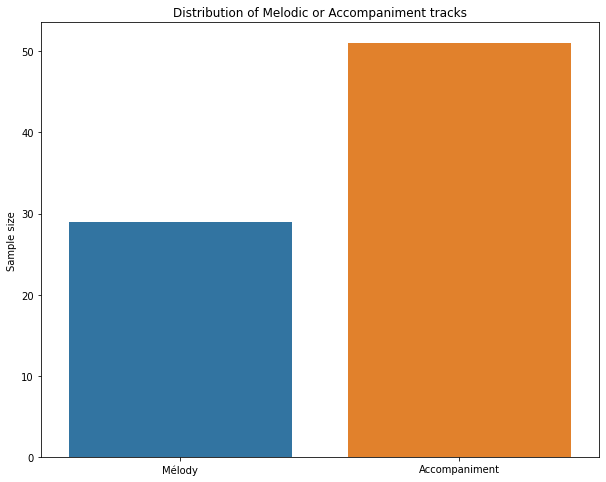

In [55]:
# 11 tracks are in melody, 45 are in accompaniment.

plt.figure(figsize=(10,8))
g = sns.barplot(x=df1.value_counts(),y=df1.value_counts()).set_title('Distribution of Melodic or Accompaniment tracks')
plt.ylabel("Sample size")
ax = plt.subplot()
ax = ax.set_xticklabels(["Mélody","Accompaniment"])

In [56]:
has_bleed = [i.replace('yes', '1') for i in has_bleed]
has_bleed = [i.replace('no', '0') for i in has_bleed]
df = pd.DataFrame(has_bleed) 

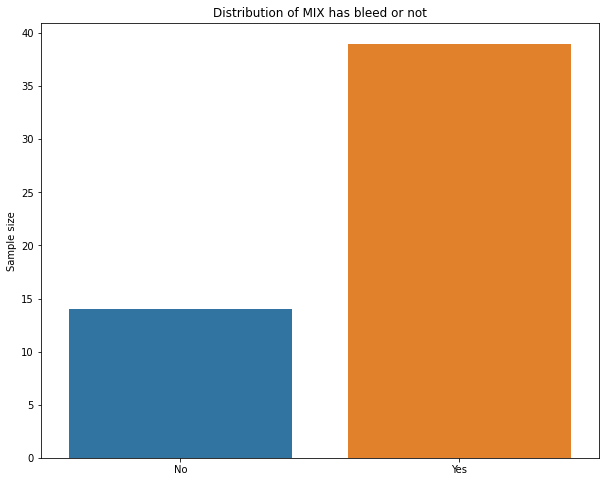

In [57]:
# 32 MIX aren't bleed, 4 MIX are.

plt.figure(figsize=(10,8))
g = sns.barplot(x=df.value_counts(),y=df.value_counts()).set_title("Distribution of MIX has bleed or not")
plt.ylabel("Sample size")
ax = plt.subplot()
ax = ax.set_xticklabels(["No","Yes"])
# save(img_path.joinpath("mon_graphe.png"))

### Spectrum modeling with the librosa library

In [379]:
# We get 2 lists to be able to compare the spectra of these 2 types of guitars

electric_stems = get_instrument_stems(metadata_df["stems"], instrument_name = 'clean electric guitar')
acoustic_stems = get_instrument_stems(metadata_df["stems"], instrument_name = 'acoustic guitar')

In [380]:
# Recreate the path to the track chooses randomly

electric_choice = random.choices(electric_stems, k = 3)
print("Our 3 tracks are : ", electric_choice)
clean_sampling_electric = ([s.split("_STEM")[0] for s in electric_choice])
clean_sampling_chiffre_electric = ([s.split("_0")[0] for s in electric_choice])

Our 3 tracks are :  ['TheDistricts_Vermont_STEM_06.wav', 'PortStWillow_StayEven_STEM_07.wav', 'FamilyBand_Again_STEM_05.wav']


In [394]:
liste_pistes_electric = []
for i in range(0,3) :
    add_electric = Path.joinpath(audio_path, clean_sampling_electric[i], (clean_sampling_chiffre_electric[i])+'S', electric_choice[i])
    liste_pistes_electric.append(add_electric)

[WindowsPath('D:/Théo/MedleyDB/V1/TheDistricts_Vermont/TheDistricts_Vermont_STEMS/TheDistricts_Vermont_STEM_06.wav'),
 WindowsPath('D:/Théo/MedleyDB/V1/PortStWillow_StayEven/PortStWillow_StayEven_STEMS/PortStWillow_StayEven_STEM_07.wav'),
 WindowsPath('D:/Théo/MedleyDB/V1/FamilyBand_Again/FamilyBand_Again_STEMS/FamilyBand_Again_STEM_05.wav')]

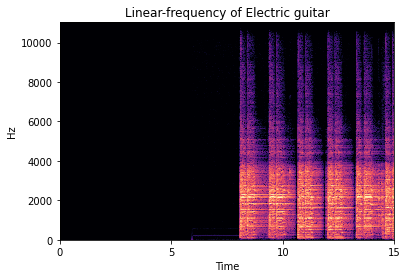

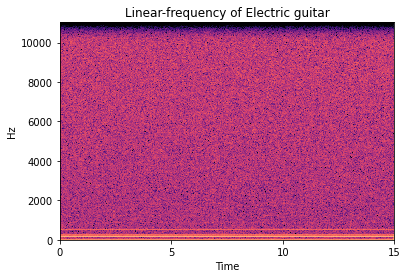

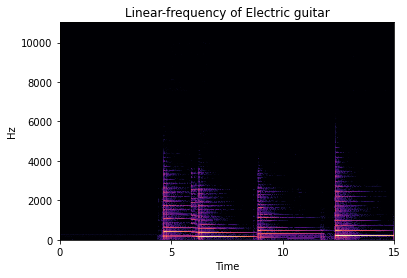

In [397]:
# Model 3 spectra of electric guitar randomly

for i in liste_pistes_electric :


    y, sr = librosa.load(i, duration=15)
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax)
    ax.set(title='Linear-frequency of Electric guitar')
    ax.label_outer()
    plt.show()

In [66]:
# We do the same procedure for acoustic guitar

acoustic_choice = random.choices(acoustic_stems, k = 3)
print("Our 3 tracks are : ", acoustic_choice)
clean_sampling_acoustic = ([s.split("_STEM")[0] for s in acoustic_choice])
clean_sampling_chiffre_acoustic = ([s.split("_0")[0] for s in acoustic_choice])

Our 3 tracks are :  ['BarefootSisters_RedJetta_STEM_02.wav', 'MusicDelta_Country1_STEM_03.wav', 'FilthyBird_IdLikeToKnow_STEM_01.wav']


In [392]:
liste_pistes_acoustic = []
for i in range(0,3) :
    add_acoustic = Path.joinpath(audio_path, clean_sampling_acoustic[i], (clean_sampling_chiffre_acoustic[i])+'S', acoustic_choice[i])
    liste_pistes_acoustic.append(add_acoustic)

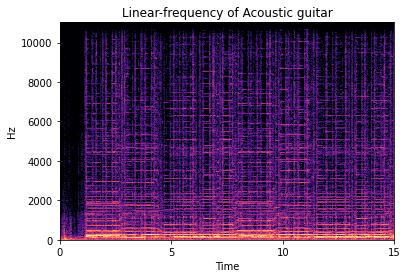

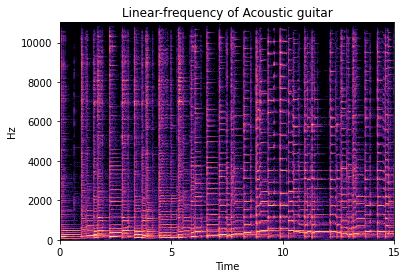

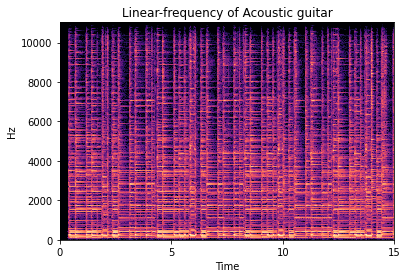

In [396]:
for i in liste_pistes_acoustic :

    y, sr = librosa.load(i, duration=15)
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                                sr=sr, ax=ax)
    ax.set(title='Linear-frequency of Acoustic guitar')
    ax.label_outer()
    plt.show()

In [9]:
# Decomposition of mix and tracks

def get_stems(track_name):

    # création du chemin vers les stems
    track_path = track_name + "_STEMS"
    stems_path = audio_path.joinpath(track_name, track_name + "_STEMS")
    # parcours des fichiers
    global stems_list
    stems_list = []
    for f in stems_path.glob('**/*.wav'):
        stems_list.append(f)
    track_stems = metadata_df.query(f"stem_dir == '{track_path}'")["stems"].iloc[0]
    track_stems = eval(track_stems)
    global instru_stems
    instru_stems = []
    # Parcours des instruments par pistes
    for s in track_stems.values():
        instru_stems.append(s["instrument"])
    
    return stems_list, instru_stems

In [12]:
# read audio samples
def get_audio(track_name):
    
    get_stems(track_name)
    plt.figure(figsize=(20,10))

    for i, s in enumerate(stems_list):
        input_data = read(s)
        audio = input_data[1]
        plt.plot(audio.T[0][0:3000], label = instru_stems[i])
        plt.legend(framealpha=1, frameon=True)

    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.title("Sample Wav")
    plt.show()

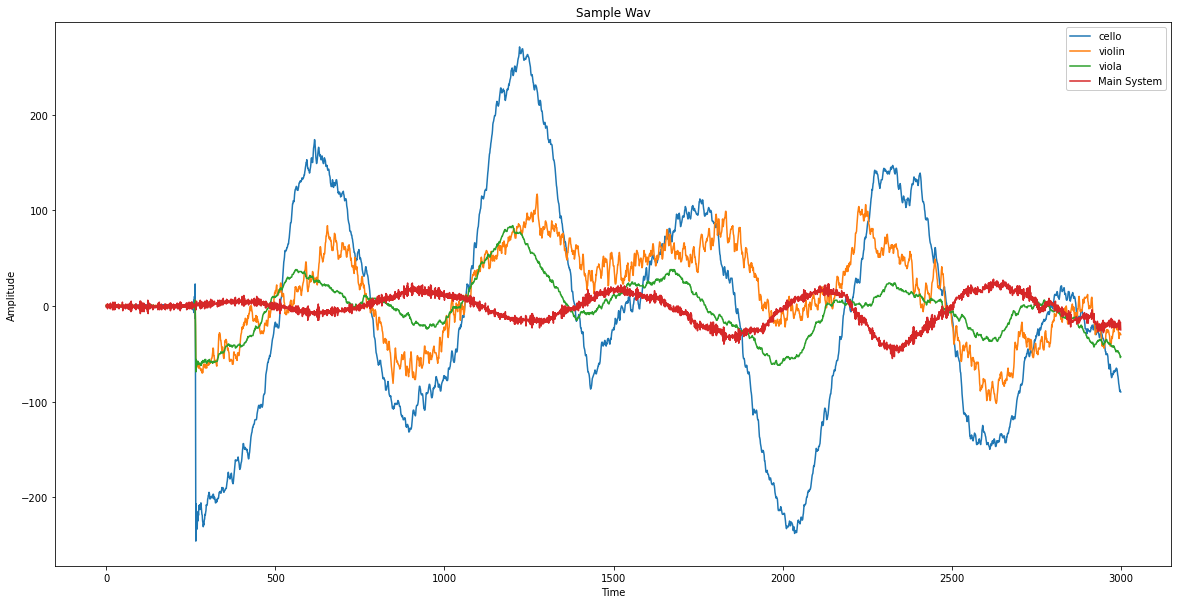

In [13]:
get_audio('AmadeusRedux_SchubertMovement2')

In [16]:
# TEST décomposition d'un mix et de ses stems
def get_linear_frequency(track_name):

    stems_list, instru_stems = get_stems(track_name)

    stems_path_mix = audio_path.joinpath(track_name, track_name + "_MIX.wav")

    y, sr = librosa.load(stems_path_mix, duration=30)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax)
    ax.set(title='Linear-frequency power spectrogram of mix')
    ax.label_outer()
    plt.show()

    fig, axs = plt.subplots(nrows=1, ncols=len(instru_stems), figsize=(20,10), sharey= True)

    for i, ax in enumerate(axs) :
        y, sr = librosa.load(stems_list[i], duration=30)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax)
        ax.set(title=str(instru_stems[i]))
        ax.label_outer()
        fig.suptitle('Linear fraquency of : ')

    plt.show()   

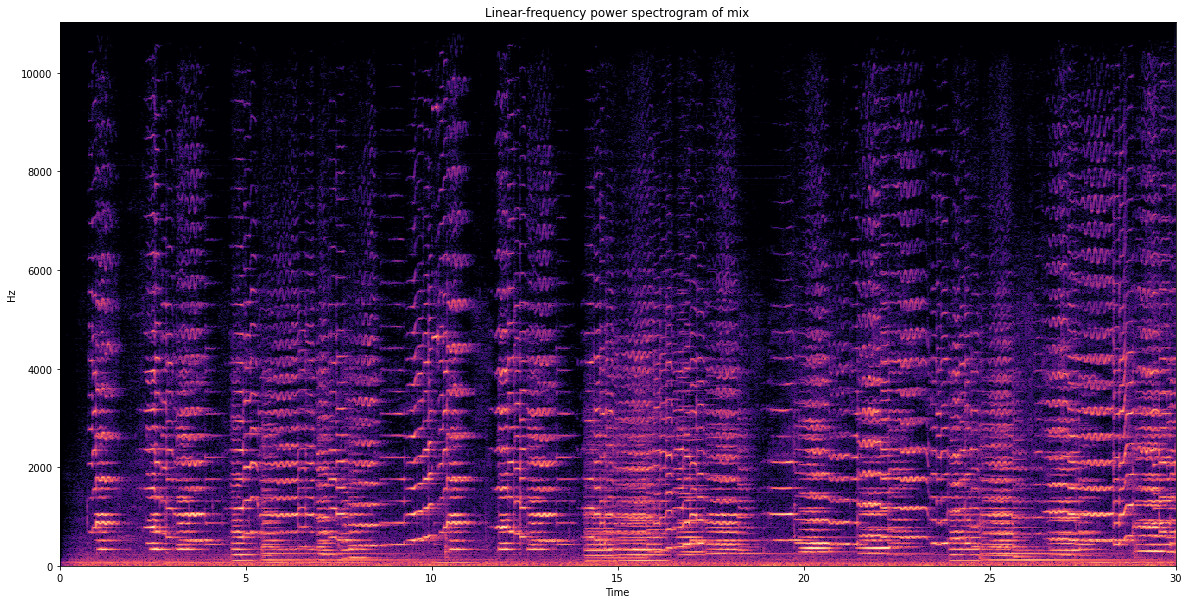

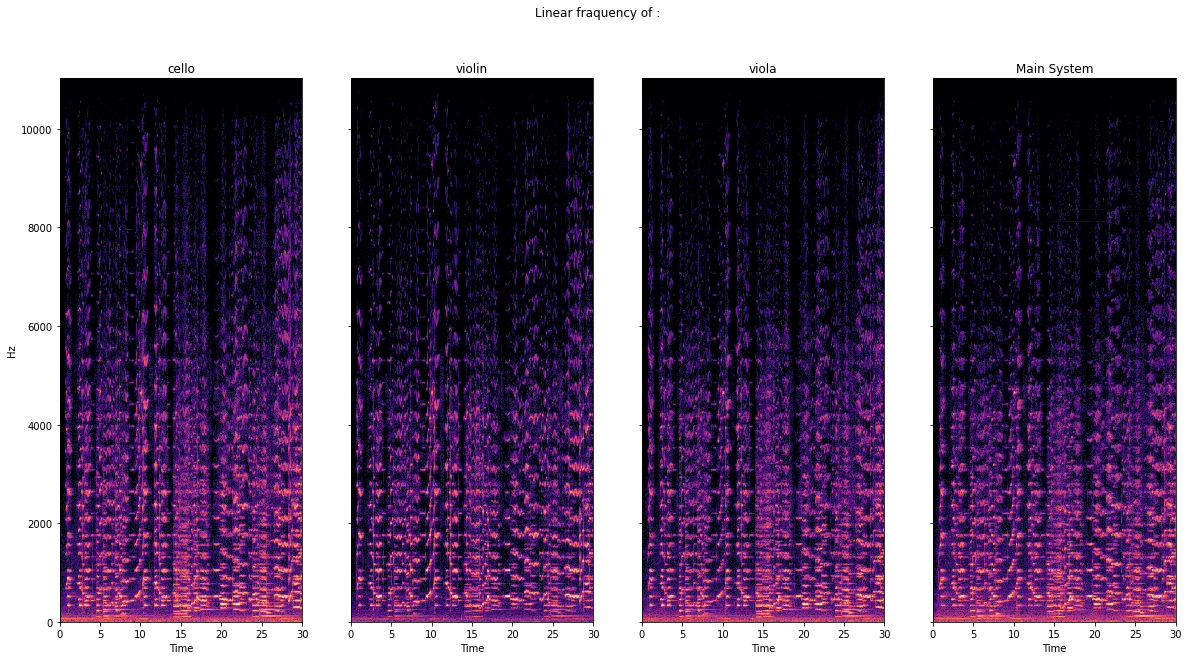

In [17]:
get_linear_frequency('AmadeusRedux_SchubertMovement2')